### Screen width adjustment

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Input variables

In [83]:
dataset = 'CZ_february_test.csv'
clusters = 'ce_tbl_payweek_clusters_feb.csv'
start_date = '2024-02-01'
end_date = '2024-02-25'

# Import packages

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import datetime
pd.set_option('display.max_columns', None)  # Display all columns without truncation
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', None)  # Set to None to display all rows
pd.set_option('display.max_colwidth', None) 

# Dataset import

In [85]:
df = pd.read_csv(dataset,parse_dates=True,low_memory=False)
df.rename(columns={'adj_sales_total_coef':'adj_sales'},inplace=True)
df['iso_date'] = pd.to_datetime(df['iso_date'])
df['promoprice_avg'] = df['promoprice_avg'].fillna(0)
df['promoprice_avg'] = df['promoprice_avg'].fillna(0)
df['normal_retailprice_avg'] = df['normal_retailprice_avg'].fillna(0)
df.sort_values(by=['RMS_ID','store_cluster','iso_date'],ascending=[True,True,True],inplace=True)
#df['BH_regressor'] = np.where(df['bank_holiday_id']==1,0,df['bank_holiday_excl'])
df['month'] = df['iso_date'].dt.month
df['year'] = df['iso_date'].dt.year
country = df.iloc[0,0]
#df.drop(columns=['large_payweek','HU_pensions_payweek','small_payweek'],inplace=True)
df.sort_values(by='iso_date',ascending=False).head()

,int_cntr_code,RMS_ID,sg_cd,dmat_div_code,dmat_dep_code,dmat_dep_des_en,dmat_sec_code,dmat_sec_des_en,dmat_grp_code,dmat_grp_des_en,dmat_sgr_code,dmat_sgr_des_en,store_cluster,iso_date,tesco_yrwk,LY_week_range,TY_week_range,fcst_week_id,weekday,event_id,bank_holiday_id,bh_lower_window,bh_upper_window,small_payday_id,large_payday_id,HU_pensions_id,monday_pensioners,bank_holiday_excl,normal_retailprice_avg,promoprice_avg,total_price_avg,store_count,tpnb_count,promo_count,adj_sales,exp_sales,seasonality_ratio,seasonality_filter,wthrfactor,scaled_tpnb_count,scaled_promo_sales,scaled_normal_retail_price,scaled_promo_price,scaled_total_price,scaled_wthrfactor,ptp_reg_weight,month,year
244638,CZ,11414091112,A38AB,1,14,MeatFishPoultry,1409,Frozen_Poultry,0011,Frozen_Poultry,0012,Chicken_Portions,Large-Moderate,2024-02-18,202351,0,0,1,7,0,0,NaN,NaN,0,0,0,0.0,0,70.971429,70.971429,70.971429,35,98,0,97.00,106.34,1.392456,0.919499,1.000000,0.0,0.000000,0.000000,-0.459184,0.000000,0.000000,0.046327,2,2024
101627,CZ,11313013411,A20OA,1,13,Dairy,1301,Milk_and_Cream,0034,UHT_MILK_DRINKS_REG,0011,MILK,Large-Intense,2024-02-18,202351,0,0,1,7,0,0,NaN,NaN,0,0,0,0.0,0,31.392571,31.392571,31.392571,40,280,0,251.58,236.61,1.192288,0.955630,0.891324,0.0,0.000000,-0.008139,-0.855895,-0.604526,0.101098,0.029629,2,2024
306512,CZ,11313081319,A27CI,1,13,Dairy,1308,Yoghurts,0013,Flavoured,0019,Others,Large-Weak,2024-02-18,202351,0,0,1,7,0,0,NaN,NaN,0,0,0,0.0,0,24.432806,9.900000,24.177845,10,196,7,342.12,326.92,1.174062,0.941272,1.227659,0.0,0.049913,-0.876035,0.000000,-0.937291,0.682701,0.021211,2,2024
114582,CZ,113130611,A25A,1,13,Dairy,1306,Counter_Cheese,0011,Hard_Cheese,-,-,Large-Intense,2024-02-18,202351,0,0,1,7,0,0,NaN,NaN,0,0,0,0.0,0,332.608519,173.938356,313.713051,40,540,146,305.57,375.61,1.534755,0.932620,1.000000,0.1,0.534671,-0.257451,-0.158811,-0.268529,0.000000,0.032940,2,2024
188986,CZ,11313011412,A20DB,1,13,Dairy,1301,Milk_and_Cream,0014,UHT_CREAM,0012,WHIPPING_CREAM,Large-Moderate,2024-02-18,202351,0,0,1,7,0,0,NaN,NaN,0,0,0,0.0,0,40.820000,40.820000,40.820000,30,89,0,65.53,86.73,1.944391,0.840730,1.000000,0.0,0.000000,-0.708727,-0.910000,-0.781056,0.000000,0.040432,2,2024


### Pay indicator original

In [86]:
def upper_w(weekday):
    mapping = {1:6,
        2:5,
        3:4,
        4:3,
        5:2}
    upper_window = mapping.get(weekday,0)
    return upper_window

df_lpay = pd.DataFrame({'iso_date':df[df['large_payday_id']==1]['iso_date']})
df_lpay['pay_event'] = 'large_pw'
df_spay = pd.DataFrame({'iso_date':df[df['small_payday_id']==1]['iso_date']})
df_spay['pay_event'] = 'small_pw'
df_pen =  pd.DataFrame({'iso_date':df[df['HU_pensions_id']==1]['iso_date']})
df_pen['pay_event'] = 'pensions'
df_lpay.drop_duplicates(inplace=True)
df_spay.drop_duplicates(inplace=True)
df_pen.drop_duplicates(inplace=True)

dfp = pd.DataFrame(pd.concat([df_lpay,df_spay,df_pen]))
dfp['day'] = pd.to_datetime(dfp['iso_date']).dt.weekday+1
dfp['lower_window'] = 0
dfp['upper_window'] = dfp['day'].apply(upper_w)
df_pay_dates = pd.DataFrame()
for index,row in dfp.iterrows():
    start_d=(row['iso_date']+pd.Timedelta(days=row['lower_window'])).strftime('%Y-%m-%d')
    end_d=(row['iso_date']+pd.Timedelta(days=row['upper_window'])).strftime('%Y-%m-%d')
    date_range = pd.date_range(start=start_d,end=end_d)
    df_inner = pd.DataFrame({'iso_date':date_range,'pay_event':row['pay_event']})
    df_pay_dates = pd.concat([df_pay_dates,df_inner])
df_pay_dates['pay_indicator'] = 1

# Large pw, small pw and HU pensions
df_pi = df_pay_dates[['iso_date','pay_indicator']].drop_duplicates()
df_lpay = df_pay_dates[df_pay_dates['pay_event']=='large_pw'][['iso_date','pay_indicator']].copy()
df_lpay.rename(columns={'pay_indicator':'large_payweek'},inplace=True)
df_spay = df_pay_dates[df_pay_dates['pay_event']=='small_pw'][['iso_date','pay_indicator']].copy()
df_spay.rename(columns={'pay_indicator':'small_payweek'},inplace=True)
df_pen = df_pay_dates[df_pay_dates['pay_event']=='pensions'][['iso_date','pay_indicator']].copy()
df_pen.rename(columns={'pay_indicator':'HU_pensions_payweek'},inplace=True)
#Cleaning of original column
df_pay_dates.drop(columns='pay_event',inplace=True)

#Connect pay ind
df = df.merge(df_pay_dates,how='left',left_on='iso_date',right_on='iso_date')
df['weekend_id'] = np.where(df['weekday'].isin([5,6,7]),1,0)
df['pay_indicator'] = df['pay_indicator'].fillna(0).astype(int)
#Connect large pw
df = df.merge(df_lpay,how='left',left_on='iso_date',right_on='iso_date')
df['large_payweek'].fillna(0,inplace=True)
#Join small pw
df = df.merge(df_spay,how='left',left_on='iso_date',right_on='iso_date')
df['small_payweek'].fillna(0,inplace=True)
#Join HU pensions
df = df.merge(df_pen,how='left',left_on='iso_date',right_on='iso_date')
df['HU_pensions_payweek'].fillna(0,inplace=True)

df = df.drop_duplicates()
df.shape

(521346, 53)

### Pay indicator user input

In [87]:
pay_input = pd.read_csv('cz_produce_manual_payind.csv')
pay_input['dmat_dep_code'] = 12
pay_input['iso_date'] = pd.to_datetime(pay_input['iso_date'])
pay_input.rename(columns={'pay_ind':'pay_indicator'},inplace=True)
pay_input.head()

,Country,Category,TY day in week,iso_date,pay_indicator,dmat_dep_code
0,CZ,Produce,4,2022-12-01,0,12
1,CZ,Produce,5,2022-12-02,0,12
2,CZ,Produce,6,2022-12-03,0,12
3,CZ,Produce,7,2022-12-04,0,12
4,CZ,Produce,1,2022-12-05,0,12


In [88]:
#df.drop(columns='pay_indicator',inplace=True)

In [89]:
#df = df.merge(pay_input[['iso_date','pay_indicator']],how='left',on=['iso_date'])
#df.shape

# Bank holiday dataframe

In [90]:
df_bh = df.copy()
df_bh = df_bh[['iso_date','bh_lower_window','bh_upper_window']][df_bh['bank_holiday_id']==1]
df_bh.rename(columns={'iso_date':'ds','bh_lower_window':'lower_window','bh_upper_window':'upper_window'},inplace=True)
df_bh['lower_window'] = df_bh['lower_window'].astype('int') - 4
df_bh['upper_window'] = df_bh['upper_window'].astype('int') + 2
df_bh.drop_duplicates(inplace=True)
df_bh['holiday'] = 'bank_holiday'
df_bh['zero_forecast'] = 0
df_bh['prior_scale'] = 40
df_bh = df_bh.reset_index(drop=True)

def upper_w(weekday):
    mapping = {1:6,
        2:5,
        3:4,
        4:3,
        5:2}
    upper_window = mapping.get(weekday,0)
    return upper_window

conditions = [
    (df['large_payday_id'] == 1),
    (df['small_payday_id'] == 1),
    (df['HU_pensions_id'] == 1)
]
holiday_names = ['large_payday', 'small_payday', 'pensions_payday']

# Iterate over conditions and holiday names
dfs = []
for condition, holiday_name in zip(conditions, holiday_names):
    df_temp = df.loc[condition, 'iso_date'].drop_duplicates().to_frame().copy()
    df_temp['day'] = df_temp['iso_date'].dt.weekday + 1
    df_temp['lower_window'] = 0
    df_temp['upper_window'] = df_temp['day'].apply(upper_w)
    df_temp['holiday'] = holiday_name
    df_temp['zero_forecast'] = np.nan
    df_temp['prior_scale'] = 15
    df_temp.drop(columns='day', inplace=True)
    df_temp.rename(columns={'iso_date': 'ds'}, inplace=True)
    dfs.append(df_temp)
# Concatenate all dataframes into a single dataframe
df_pay = pd.concat(dfs, ignore_index=True)

df_bh_pay = pd.concat([df_bh,df_pay])
df_bh_pay.drop(columns='zero_forecast',inplace=True)


## PCA

In [91]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
regressors = ['scaled_promo_sales','scaled_wthrfactor','scaled_promo_price']

In [92]:
data_all = pd.DataFrame()
for rms in df['RMS_ID'].unique():
    for cluster in df[df['RMS_ID'] == rms]['store_cluster'].unique():
        # Filter the data for the current RMS_ID and store_cluster
        data = df[(df['RMS_ID'] == rms) & (df['store_cluster'] == cluster)].copy()
        pca = PCA()
        data_pca = pca.fit_transform(data[regressors])
        n_components = 2
        data_pca_selected = data_pca[:, :n_components]
        
        #per_var = np.round(pca.explained_variance_ratio_*100,decimals=1)
        #labels = ['PC'+ str(x) for x in range(1,len(per_var)+1)]
        #plt.bar(x=range(1,len(per_var)+1),height=per_var,tick_label=labels)
        #plt.ylabel('Percentage of explained variance')
        #plt.xlabel('Principal Component')
        #plt.title('Scree plot')
        #plt.show()
        
        data_pca_df = pd.DataFrame(data_pca_selected, columns=[f'PC{i+1}' for i in range(n_components)])
        data_pca_df.reset_index(drop=True,inplace=True)
        data.reset_index(drop=True,inplace=True)
        data2 = pd.concat([data, data_pca_df], axis=1)
        data_all = pd.concat([data_all,data2], axis=0)

In [93]:
data_all.shape

(521346, 55)

# Prophet model

In [94]:
from prophet import Prophet
import pandas as pd
import numpy as np
import warnings
import logging

# Suppress RuntimeWarnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
# Get the logger for cmdstanpy
cmdstanpy_logger = logging.getLogger('cmdstanpy')
# Remove existing handlers
for handler in cmdstanpy_logger.handlers:
    cmdstanpy_logger.removeHandler(handler)
# Add a new handler with ERROR level
handler = logging.StreamHandler()
handler.setLevel(logging.ERROR)
cmdstanpy_logger.addHandler(handler)

In [133]:
#df_forecasted = data_all[data_all['fcst_week_id']==1].copy()
df_forecasted = data_all.copy()
df_forecasted.rename(columns={'iso_date':'ds'},inplace=True)
df_train = data_all[data_all['fcst_week_id']==0]
df_train = df_train[df_train['dmat_dep_code']==12]
#df_train = df_train[df_train['RMS_ID']==11212031311]
last_d = max(df_train['iso_date']).strftime('%Y-%m-%d')
country = str(df_train['int_cntr_code'].unique()[0])
if country == 'HU':
    df_train_p = df_train[['RMS_ID','store_cluster','iso_date','adj_sales','small_payweek','large_payweek','HU_pensions_payweek','scaled_tpnb_count','scaled_promo_sales','scaled_normal_retail_price','scaled_total_price','scaled_promo_price','PC1','PC2','seasonality_ratio','seasonality_filter','ptp_reg_weight']]
else:
    df_train_p = df_train[['RMS_ID','store_cluster','iso_date','adj_sales','small_payweek','large_payweek','scaled_tpnb_count','scaled_promo_sales','scaled_normal_retail_price','scaled_total_price','scaled_promo_price','PC1','PC2','seasonality_ratio','seasonality_filter','ptp_reg_weight']]    
df_train_p = df_train_p.rename(columns={'iso_date':'ds','adj_sales':'y'})
df_train_p.shape

(180264, 16)

### Model instantiation

In [136]:
df_res = pd.DataFrame()
for rms in df_train_p['RMS_ID'].unique():
    for cluster in df_train_p[df_train_p['RMS_ID']==rms]['store_cluster'].unique():
        data = df_train_p[(df_train_p['RMS_ID']==rms)&(df_train_p['store_cluster']==cluster)].copy()
        floor_if = np.round(data['y'].drop_duplicates().nsmallest(2).iloc[-1],0)
        seasonality_ratio = max(data['seasonality_ratio'])
        floor = np.round(min(data['y']),0)
        cap = np.round(max(data['y']),0)
        data['floor'] = floor_if
        data['cap'] = cap
        week_std = max(data['ptp_reg_weight'])
          
        #PARAMETERS
        if str(rms)[:3] == '112':
            m = Prophet(growth='logistic',holidays=df_bh_pay,daily_seasonality=False,weekly_seasonality=False,yearly_seasonality=False,changepoint_prior_scale=0.5,seasonality_prior_scale=0.5)
        else:
            m = Prophet(growth='logistic',holidays=df_bh_pay,daily_seasonality=False,weekly_seasonality=False,yearly_seasonality=False,changepoint_prior_scale=0.5,seasonality_prior_scale=0.015)     
        m.add_country_holidays(country_name=country)
        m.add_seasonality(name='monthly',period=30.25,fourier_order=5,prior_scale=0.001)
        if week_std < 0.015 or (seasonality_filter < 0.3 and seasonality_ratio > 4):
            m.add_seasonality(name='weekly', period=7, fourier_order=5,prior_scale=0.0025)       
        else:
            m.add_seasonality(name='weekly', period=7, fourier_order=10)
        if str(rms)[:3] == '112':
            if  seasonality_ratio > 7:
                m.add_seasonality(name='yearly', period=365.25,fourier_order=20)
                m.add_regressor('scaled_tpnb_count', prior_scale=0.015,mode='multiplicative')
                m.add_regressor('scaled_total_price',prior_scale=0.015,mode='multiplicative')
                m.add_regressor('PC1',prior_scale=0.15,mode='multiplicative')
                m.add_regressor('PC2',prior_scale=0.005,mode='multiplicative')
            elif seasonality_ratio > 3:
                m.add_seasonality(name='yearly', period=365.25, fourier_order=15)
                m.add_regressor('scaled_tpnb_count', prior_scale=0.0015,mode='multiplicative')
                m.add_regressor('scaled_total_price',prior_scale=0.015,mode='multiplicative')
                m.add_regressor('PC1',prior_scale=0.01,mode='multiplicative')
                m.add_regressor('PC2',prior_scale=0.01,mode='multiplicative')
            else:
                m.add_seasonality(name='yearly', period=365.25, fourier_order=9,prior_scale=0.001)
                m.add_regressor('scaled_tpnb_count', prior_scale=0.0015,mode='multiplicative')
                m.add_regressor('scaled_total_price',prior_scale=0.015,mode='multiplicative')
                m.add_regressor('PC1',prior_scale=0.01,mode='multiplicative')
                m.add_regressor('PC2',prior_scale=0.01,mode='multiplicative')
        elif str(rms)[:3] == '114':
            m.add_regressor('scaled_tpnb_count', prior_scale=0.015,mode='multiplicative')
            m.add_regressor('scaled_total_price',prior_scale=0.015,mode='multiplicative')
            m.add_regressor('PC1',prior_scale=0.01,mode='multiplicative')
            m.add_regressor('PC2',prior_scale=0.01,mode='multiplicative')
            if  seasonality_ratio > 7:
                m.add_seasonality(name='yearly', period=365.25,fourier_order=15) #10
            elif seasonality_ratio > 3:
                m.add_seasonality(name='yearly', period=365.25, fourier_order=5,prior_scale=0.005) #3
            else:
                m.add_seasonality(name='yearly', period=365.25, fourier_order=1,prior_scale=0.001) #1
        elif str(rms)[:3] == '113':
            m.add_regressor('scaled_tpnb_count', prior_scale=0.001,mode='multiplicative')
            m.add_regressor('scaled_total_price',prior_scale=0.001,mode='multiplicative') # 0.015
            m.add_regressor('PC1',prior_scale=0.01,mode='multiplicative')
            #m.add_regressor('PC2',prior_scale=0.01,mode='multiplicative')
            if seasonality_ratio > 3: 
                m.add_seasonality(name='yearly', period=365.25,fourier_order=3) 
            else:
                m.add_seasonality(name='yearly', period=365.25, fourier_order=1) 
        m.add_regressor('small_payweek',prior_scale=0.05,mode='additive')
        m.add_regressor('large_payweek',prior_scale=0.05,mode='additive')
        data.drop(columns='seasonality_ratio',inplace=True)
        
        #MODEL FITTING        
        m.fit(data)
        future = m.make_future_dataframe(periods=28)
        future['RMS_ID'] = rms
        future['store_cluster'] = cluster
        future['floor'] = floor_if
        future['cap'] = cap
        if country == 'HU':
            future = future.merge(df_forecasted[['RMS_ID','store_cluster','ds','small_payweek','large_payweek','HU_pensions_payweek','scaled_tpnb_count','scaled_promo_sales','scaled_normal_retail_price','scaled_total_price','scaled_promo_price','PC1','PC2']],on=['RMS_ID','store_cluster','ds'])
        else:
            future = future.merge(df_forecasted[['RMS_ID','store_cluster','ds','small_payweek','large_payweek','scaled_tpnb_count','scaled_promo_sales','scaled_normal_retail_price','scaled_total_price','scaled_promo_price','PC1','PC2']],on=['RMS_ID','store_cluster','ds'])            
        forecast = m.predict(future)
        forecast = pd.merge(forecast, df_bh[['ds', 'zero_forecast']], how='left', on='ds')
        forecast['zero_forecast'] = forecast['zero_forecast'].fillna(1)
        forecast['yhat'] = forecast['zero_forecast'] * forecast['yhat']
        forecast = forecast[['ds','yhat','trend']]
        forecast['RMS_ID'] = rms
        forecast['store_cluster'] = cluster
        forecast['weekday'] = forecast['ds'].dt.weekday + 1
        df_res = pd.concat([df_res,forecast])

### Evaluation 

In [137]:
df_fcst_base = df.merge(df_res,how='left',left_on=['iso_date','RMS_ID','store_cluster'],right_on=['ds','RMS_ID','store_cluster']).drop(columns=['ds'])
df_fcst = df_fcst_base.copy()
df_fcst['diff_model'] = np.abs(df_fcst['yhat'] - df_fcst['adj_sales'])
df_fcst['diff_user'] = np.abs(df_fcst['exp_sales']-df_fcst['adj_sales'])
df_fcst['bias_model'] = df_fcst['yhat'] - df_fcst['adj_sales']
df_fcst['bias_user'] = df_fcst['exp_sales'] - df_fcst['adj_sales']
df_fcst = df_fcst[df_fcst['fcst_week_id']==1]
df_fcst['unique_id'] = df_fcst['RMS_ID'].astype(str)+df_fcst['store_cluster']

groupby = df_fcst.groupby(['int_cntr_code','dmat_dep_des_en']).apply(
    lambda x: (np.round(np.sum(x['diff_model']) / np.sum(x['adj_sales']),4)
               ,np.round(np.sum(x['diff_user']) / np.sum(x['adj_sales']),4)
               ,np.round(np.sum(x['bias_model']) / np.sum(x['adj_sales']),4)
               ,np.round(np.sum(x['bias_user']) / np.sum(x['adj_sales']),4)
               ,x['unique_id'].nunique())).reset_index()
groupby_df = pd.DataFrame(groupby)
groupby_df[['model_err','base_err','model_bias','base_bias','hier_cluster_count']] = groupby_df[0].apply(pd.Series)
groupby_df['diff'] = groupby_df['model_err']-groupby_df['base_err']
groupby_df['hier_cluster_count'] = groupby_df['hier_cluster_count'].astype('int')
groupby_df.drop(columns= [0],inplace=True)

import calendar
country = str(df_fcst['int_cntr_code'].unique()[0]).upper()
month = calendar.month_name[df_fcst['iso_date'].max().month]
filename = country + "_" + month + "_results.csv"
groupby_df.to_csv(filename,index=False)

groupby_df.sort_values(by='diff',ascending=False)

,int_cntr_code,dmat_dep_des_en,model_err,base_err,model_bias,base_bias,hier_cluster_count,diff
2,CZ,Produce,0.1666,0.0935,-0.0444,0.0036,561,0.0731
1,CZ,MeatFishPoultry,0.0000,0.1330,0.0000,-0.0229,130,-0.1330
0,CZ,Dairy,0.0000,0.1391,0.0000,0.0778,800,-0.1391


In [98]:
groupby = df_fcst.groupby(['int_cntr_code','dmat_dep_des_en','iso_date']).apply(
    lambda x: (np.round(np.sum(x['diff_model']) / np.sum(x['adj_sales']),4)
               ,np.round(np.sum(x['diff_user']) / np.sum(x['adj_sales']),4)
               ,np.round(np.sum(x['bias_model']) / np.sum(x['adj_sales']),4)
               ,np.round(np.sum(x['bias_user']) / np.sum(x['adj_sales']),4)
               ,x['unique_id'].nunique())).reset_index()
groupby_df = pd.DataFrame(groupby)
groupby_df[['model_err','base_err','model_bias','base_bias','hier_cluster_count']] = groupby_df[0].apply(pd.Series)
groupby_df['diff'] = groupby_df['model_err']-groupby_df['base_err']
groupby_df.drop(columns= [0],inplace=True)
groupby_df_date = groupby_df[(groupby_df['iso_date']>='2023-09-08')&(groupby_df['iso_date']<='2023-09-20')]
groupby_df_date.sort_values(by=['dmat_dep_des_en','iso_date'],ascending=[True,True]).head(70)

,int_cntr_code,dmat_dep_des_en,iso_date,model_err,base_err,model_bias,base_bias,hier_cluster_count,diff


In [117]:
groupby = df_fcst.groupby(['int_cntr_code','dmat_dep_des_en','RMS_ID','store_cluster','seasonality_ratio','seasonality_filter','ptp_reg_weight']).apply(lambda x: (np.round(np.sum(x['diff_model']) / np.sum(x['adj_sales']),4), np.round(np.sum(x['diff_user']) / np.sum(x['adj_sales']),4))).reset_index()
groupby_df = pd.DataFrame(groupby)
groupby_df[['model_err','base_err']] = groupby_df[0].apply(pd.Series)
groupby_df['diff'] = groupby_df['model_err']-groupby_df['base_err']
groupby_df.drop(columns= [0],inplace=True)
groupby_df.sort_values(by='diff',ascending=False).head(50)

,int_cntr_code,dmat_dep_des_en,RMS_ID,store_cluster,seasonality_ratio,seasonality_filter,ptp_reg_weight,model_err,base_err,diff
1146,CZ,Produce,112120513,Large-Intense,5.873604,0.286756,0.052859,1.1114,0.3781,0.7333
1147,CZ,Produce,112120513,Large-Moderate,6.277078,0.301035,0.056280,0.9215,0.4213,0.5002
1377,CZ,Produce,11212041213,Large-Intense,4.388897,0.745601,0.019953,0.6246,0.1535,0.4711
1379,CZ,Produce,11212041213,Large-Weak,5.053107,0.752651,0.016586,0.5914,0.1210,0.4704
1378,CZ,Produce,11212041213,Large-Moderate,5.003190,0.736316,0.020438,0.5926,0.1338,0.4588
1380,CZ,Produce,11212041213,Small-Intense,5.821596,0.649661,0.024150,0.6244,0.1820,0.4424
1107,CZ,Produce,112120412,Small-Intense,5.329185,0.578807,0.024150,0.6242,0.1820,0.4422
1149,CZ,Produce,112120513,Small-Intense,8.472126,0.777855,0.047742,0.8574,0.4221,0.4353
1148,CZ,Produce,112120513,Large-Weak,5.150231,0.354149,0.042056,0.8588,0.4478,0.4110
1179,CZ,Produce,112120616,Large-Moderate,99.284075,0.781315,0.020904,0.4388,0.0335,0.4053


In [100]:
filename2 = country + "_" + month + "_worst_hierarchies_1regressor_price.csv"
groupby_df.to_csv(filename2,index=False)

### Uplift calculation

In [101]:
def calc_algo_uplift(row):
    if row['lw_sum_bh'] > 0:
        if row['2w_sum_bh'] > 0:
            if row['2w_bank_holiday'] > 0:
                return 'lw_daily'
            else:
                return "2w_daily"
        else:
            return '2w'
    else:
        return 'lw'
    
def uplift_capping_bh(bh,uplift):
    if bh == 1:
        if uplift > 2.5:
            return 2.5
        elif uplift < 0.50:
            return 0.50
        else:
            return uplift  
    else:
        if uplift > 1.35:
            return 1.35
        elif uplift < 1:
            return 1
        else:
            return uplift

In [102]:
cols=['int_cntr_code','RMS_ID','sg_cd','iso_date','bank_holiday_id','bank_holiday_excl','weekday_x','store_cluster','scaled_tpnb_count','scaled_promo_sales','pay_indicator','tesco_yrwk','yhat','adj_sales','exp_sales','diff_model',
       'diff_user','fcst_week_id','trend']
df_fcst_a = df_fcst.copy()
df_fcst_a = df_fcst_a[cols]
df_fcst_a.rename(columns={'weekday_x':'weekday'},inplace=True)
df_fcst_join = df_fcst_a.copy()
cols2=['int_cntr_code','RMS_ID','sg_cd','dmat_sec_des_en','dmat_grp_des_en','dmat_sgr_des_en','iso_date','bank_holiday_id','bank_holiday_excl','weekday_x','store_cluster','scaled_tpnb_count','scaled_promo_sales','pay_indicator','tesco_yrwk','yhat','adj_sales','exp_sales','diff_model','diff_user','wthrfactor','tpnb_count','fcst_week_id','trend',]
df_base = df_fcst_base.copy()
df_base['diff_model'] = np.nan
df_base['diff_user'] = np.nan
df_base = df_base[cols2].copy()
df_base = df_base[df_base['fcst_week_id']==0]
#df_base.drop(columns=['fcst_week_id'],inplace=True)
df_fcst_join = pd.concat([df_fcst_join,df_base])
df_fcst_join['yhat'] = df_fcst_join['yhat'].combine_first(df_fcst_join['adj_sales'])

# last week connection
df_fcst_join['iso_date_join'] = df_fcst_join['iso_date'] + timedelta(days=7)
df_fcst_merged = df_fcst.merge(df_fcst_join[['RMS_ID','store_cluster','iso_date_join','yhat','adj_sales','bank_holiday_excl']],how='left',left_on=['RMS_ID','iso_date','store_cluster'],right_on=['RMS_ID','iso_date_join','store_cluster'])
df_fcst_merged = df_fcst_merged[[col for col in df_fcst_merged.columns if col not in ['diff_user','iso_date_join']]].sort_values(by=['RMS_ID','store_cluster','iso_date'])
df_fcst_merged.rename({'yhat_x':'fcst_sales','yhat_y':'lw_fcst_sales','adj_sales_x':'adj_sales','adj_sales_y':'lw_adj_sales','bank_holiday_excl_y':'lw_bank_holiday','bank_holiday_excl_x':'bank_holiday_tw','weekday_x':'weekday'},axis=1,inplace=True)
df_fcst_merged['lw_daily_uplift'] = np.round(df_fcst_merged['fcst_sales']/df_fcst_merged['lw_fcst_sales'],3)

#Calculations for weekend and week + rounding
df_fcst_merged['fcst_sales'] = np.round(df_fcst_merged['fcst_sales'],2)
df_fcst_merged['weekend'] = np.where(df_fcst_merged['weekday'].isin([5,6,7]),1,0)
df_fcst_merged['sum_fcst_week'] = df_fcst_merged.groupby(['RMS_ID', 'store_cluster','tesco_yrwk'])['fcst_sales'].transform('sum')
df_fcst_merged['sum_fcst_weekend'] = df_fcst_merged.groupby(['RMS_ID', 'store_cluster','tesco_yrwk','weekend'])['fcst_sales'].transform('sum')
df_fcst_merged = df_fcst_merged[['int_cntr_code','RMS_ID','sg_cd','dmat_sec_des_en','dmat_grp_des_en','dmat_sgr_des_en','store_cluster','tesco_yrwk','iso_date','bank_holiday_id','weekday','weekend','pay_indicator','bank_holiday_tw','adj_sales','exp_sales','fcst_sales','sum_fcst_week','sum_fcst_weekend','lw_fcst_sales','lw_adj_sales','lw_bank_holiday','lw_daily_uplift','wthrfactor','tpnb_count','fcst_week_id','trend']]

# LW
#Weekly uplift
df_fcst_merged['lw_sum_fcst'] = df_fcst_merged.groupby(['RMS_ID', 'store_cluster','tesco_yrwk'])['lw_fcst_sales'].transform('sum')
df_fcst_merged['lw_sum_bh'] = df_fcst_merged.groupby(['RMS_ID', 'store_cluster','tesco_yrwk'])['lw_bank_holiday'].transform('sum')
df_fcst_merged['lw_weekly_uplift'] = np.round(df_fcst_merged['sum_fcst_week']/df_fcst_merged['lw_sum_fcst'],3)
#Weekend uplift
df_fcst_merged['lw_sum_fcst_weekend'] = df_fcst_merged.groupby(['RMS_ID', 'store_cluster','tesco_yrwk','weekend'])['lw_fcst_sales'].transform('sum')
df_fcst_merged['lw_sum_weekend_bh'] = df_fcst_merged.groupby(['RMS_ID', 'store_cluster','tesco_yrwk','weekend'])['lw_bank_holiday'].transform('sum')
df_fcst_merged['lw_weekend_uplift'] = np.round(df_fcst_merged['sum_fcst_weekend']/df_fcst_merged['lw_sum_fcst_weekend'],3)

# 2 weeks ago connection
df_fcst_join['iso_date_join2'] = df_fcst_join['iso_date'] + timedelta(days=14)
df_fcst_merged = df_fcst_merged.merge(df_fcst_join[['RMS_ID','store_cluster','iso_date_join2','yhat','adj_sales','bank_holiday_excl']],how='left',left_on=['RMS_ID','iso_date','store_cluster'],right_on=['RMS_ID','iso_date_join2','store_cluster'])
df_fcst_merged = df_fcst_merged[[col for col in df_fcst_merged.columns if col not in ['diff_user','iso_date_join2','bank_holiday_excl_x']]].sort_values(by=['RMS_ID','store_cluster','iso_date'])
df_fcst_merged.rename({ 'yhat':'2w_fcst_sales','adj_sales_x':'adj_sales','adj_sales_y':'2w_adj_sales','bank_holiday_excl':'2w_bank_holiday'},axis=1,inplace=True)
df_fcst_merged['2w_daily_uplift'] = np.round(df_fcst_merged['fcst_sales']/df_fcst_merged['2w_fcst_sales'],3)

# 2WEEKS AGO
#Weekly uplift
df_fcst_merged['2w_sum_fcst'] = df_fcst_merged.groupby(['RMS_ID', 'store_cluster','tesco_yrwk'])['2w_fcst_sales'].transform('sum')
df_fcst_merged['2w_sum_bh'] = df_fcst_merged.groupby(['RMS_ID', 'store_cluster','tesco_yrwk'])['2w_bank_holiday'].transform('sum')
df_fcst_merged['2w_weekly_uplift'] = np.round(df_fcst_merged['sum_fcst_week']/df_fcst_merged['2w_sum_fcst'],3)
#Weekend uplift
df_fcst_merged['2w_sum_fcst_weekend'] = df_fcst_merged.groupby(['RMS_ID', 'store_cluster','tesco_yrwk','weekend'])['2w_fcst_sales'].transform('sum')
df_fcst_merged['2w_sum_weekend_bh'] = df_fcst_merged.groupby(['RMS_ID', 'store_cluster','tesco_yrwk','weekend'])['2w_bank_holiday'].transform('sum')
df_fcst_merged['2w_weekend_uplift'] = np.round(df_fcst_merged['sum_fcst_weekend']/df_fcst_merged['2w_sum_fcst_weekend'],3)

#Final model uplift
df_fcst_merged['calc_method'] = df_fcst_merged.apply(calc_algo_uplift,axis=1)

df_fcst_merged['lw_model_uplift'] = np.round((df_fcst_merged['lw_weekly_uplift']*0.333+df_fcst_merged['lw_weekend_uplift']*0.333+df_fcst_merged['lw_daily_uplift']*0.333),2)
df_fcst_merged['2w_model_uplift'] = np.round((df_fcst_merged['2w_weekly_uplift']*0.333+df_fcst_merged['2w_weekend_uplift']*0.333+df_fcst_merged['2w_daily_uplift']*0.333),2)
df_fcst_merged['lw_daily_model_uplift'] = np.round((df_fcst_merged['lw_daily_uplift']),2)
df_fcst_merged['2w_daily_model_uplift'] = np.round((df_fcst_merged['2w_daily_uplift']),2)
df_fcst_merged['final_model_uplift'] = np.where(df_fcst_merged['calc_method']=='lw',df_fcst_merged['lw_model_uplift'],np.where(df_fcst_merged['calc_method']=='2w',df_fcst_merged['2w_model_uplift'],np.where(df_fcst_merged['calc_method']=='lw_daily',df_fcst_merged['lw_daily_model_uplift'],df_fcst_merged['2w_daily_model_uplift'])))
df_fcst_merged['final_model_uplift'] = np.where(df_fcst_merged['bank_holiday_tw']==1,np.where(df_fcst_merged['calc_method']=='lw',df_fcst_merged['lw_daily_model_uplift'],np.where(df_fcst_merged['calc_method']=='2w',df_fcst_merged['2w_daily_model_uplift'],np.where(df_fcst_merged['calc_method']=='lw_daily',df_fcst_merged['lw_daily_model_uplift'],df_fcst_merged['2w_daily_model_uplift']))),df_fcst_merged['final_model_uplift'])
df_fcst_merged['final_model_uplift'] = df_fcst_merged.apply(lambda row: uplift_capping_bh(row['bank_holiday_tw'], row['final_model_uplift']), axis=1)
df_fcst_merged['final_model_uplift'] = df_fcst_merged.apply(lambda row: row['final_model_uplift'] if row['bank_holiday_id'] == 0 else 1, axis=1)

### Mapping store-cluster

In [103]:
store_map = pd.read_csv(clusters)
store_map = store_map[['int_cntr_code','RMS_ID','store','store_cluster']]
store_map['RMS_ID'] = store_map['RMS_ID'].astype(str)
store_map.head(3)

,int_cntr_code,RMS_ID,store,store_cluster
0,CZ,114,1068,Large-Heavy
1,SK,112,1031,Large-Heavy
2,SK,112,1040,Large-Heavy


### Generating csv file for backtesting

In [104]:
df_fcst_export = df_fcst_merged[['int_cntr_code','RMS_ID','sg_cd','dmat_sec_des_en','dmat_grp_des_en','dmat_sgr_des_en','iso_date','weekday','fcst_week_id','store_cluster','pay_indicator','wthrfactor','tpnb_count','fcst_sales','trend','final_model_uplift']].copy()  #[(df_fcst_merged['small_payweek']==1)|(df_fcst_merged['large_payweek']==1)]
df_fcst_export['wthr_increase'] = df_fcst_export['wthrfactor'].apply(lambda x: x-1 if x>1 else 0)
df_fcst_export['final_model_uplift'] = np.round((df_fcst_export['final_model_uplift']-1),2)
df_fcst_export['final_model_uplift'] = df_fcst_export.apply(lambda row: row['final_model_uplift'] - row['wthr_increase'] if row['final_model_uplift'] > row['wthr_increase'] else row['final_model_uplift'], axis=1).round(2)
df_fcst_export['final_model_uplift'] = df_fcst_export['final_model_uplift']*100

df_fcst_export2 = df_fcst_export[(df_fcst_export['iso_date']>=start_date)&(df_fcst_export['iso_date']<=end_date)].copy()
df_fcst_export2.loc[:,'RMS_ID_map'] = df_fcst_export2['RMS_ID'].astype(str).str[:3]
df_fcst_export2['final_model_uplift'] = df_fcst_export['final_model_uplift']/100
df_fcst_export2 = df_fcst_export2.merge(store_map,left_on=['int_cntr_code','RMS_ID_map','store_cluster'],right_on=['int_cntr_code','RMS_ID','store_cluster'])
df_fcst_export2.drop(columns=['RMS_ID_y','RMS_ID_map'],inplace=True)
df_fcst_export2.rename(columns={'RMS_ID_x':'RMS_ID'},inplace=True)
df_fcst_export2.to_csv('Backtesting_'+ country + '_' + start_date + '_' + end_date + '.csv',index=False)
df_fcst_export2.head()

,int_cntr_code,RMS_ID,sg_cd,dmat_sec_des_en,dmat_grp_des_en,dmat_sgr_des_en,iso_date,weekday,fcst_week_id,store_cluster,pay_indicator,wthrfactor,tpnb_count,fcst_sales,trend,final_model_uplift,wthr_increase,store
0,CZ,1121201,A10,Vegetable,-,-,2024-02-01,4,1,Large-Heavy,0,0.924195,530,3800.34,7502.702199,0.0,0.0,1025
1,CZ,1121201,A10,Vegetable,-,-,2024-02-01,4,1,Large-Heavy,0,0.924195,530,3800.34,7502.702199,0.0,0.0,1055
2,CZ,1121201,A10,Vegetable,-,-,2024-02-01,4,1,Large-Heavy,0,0.924195,530,3800.34,7502.702199,0.0,0.0,1013
3,CZ,1121201,A10,Vegetable,-,-,2024-02-01,4,1,Large-Heavy,0,0.924195,530,3800.34,7502.702199,0.0,0.0,1112
4,CZ,1121201,A10,Vegetable,-,-,2024-02-01,4,1,Large-Heavy,0,0.924195,530,3800.34,7502.702199,0.0,0.0,1021


## Validation tool preparation

In [105]:
df_fcst_export.rename(columns={'fcst_sales':'adj_sales',                             
                              'dmat_sec_des_en':'section',
                              'dmat_grp_des_en':'group',
                              'dmat_sgr_des_en':'subgroup',
                              'final_model_uplift':'draft_uplift'},inplace=True)
df_base_valid = df_base[['int_cntr_code','RMS_ID','sg_cd','dmat_sec_des_en','dmat_grp_des_en','dmat_sgr_des_en','iso_date','weekday_x','fcst_week_id','store_cluster','pay_indicator','wthrfactor','tpnb_count','adj_sales','trend']].copy()
df_base_valid.rename(columns={'weekday_x':'weekday',
                              'dmat_sec_des_en':'section',
                              'dmat_grp_des_en':'group',
                              'dmat_sgr_des_en':'subgroup'},inplace=True)
df_base_valid['draft_uplift'] = np.nan
df_validation = pd.concat([df_base_valid,df_fcst_export])
df_validation = df_validation.sort_values(by=['RMS_ID','store_cluster','iso_date'],ascending=[True,True,True])
df_validation['final_uplift'] = df_validation['draft_uplift']
df_validation['wthrfactor'] = df_validation['wthrfactor'].apply(lambda x: round(x,2))

# Test (can be deleted)
RMS_ID = 114140911
cluster = 'Large-Heavy'
df_validation = df_validation[(df_validation['RMS_ID']==RMS_ID)&(df_validation['store_cluster']==cluster)]

#Dates 
maxdate = df_validation['iso_date'].max()
maxdate_LY = maxdate - pd.DateOffset(years=1) 
weekday_diff = maxdate.weekday()-maxdate_LY.weekday()
TY_to = max(df_validation['iso_date'])
TY_from = TY_to - pd.Timedelta(days=45)
LY_to = (TY_to - pd.DateOffset(years=1)) + pd.Timedelta(days=weekday_diff)
LY_from = (TY_from - pd.DateOffset(years=1)) + pd.Timedelta(days=weekday_diff)

#TY and LY dataframes creation
df_validation_TY = df_validation[(df_validation['iso_date'] <= TY_to) & (df_validation['iso_date'] >= TY_from)].copy()
df_validation_TY = df_validation_TY.assign(uplift_override=0)
df_validation_LY = df_validation[(df_validation['iso_date'] <= LY_to) & (df_validation['iso_date'] >= LY_from)].copy()

In [106]:
def remove_second_level(level):
    if pd.isna(level[1]):
        return level[0]
    else:
        return level[1]

#TY transformations
df_validation_TY['trend'] = df_validation_TY['trend'].round(1)
df_validation_TY = pd.melt(df_validation_TY, id_vars=['int_cntr_code','RMS_ID','iso_date','store_cluster','sg_cd','section','group','subgroup'],value_vars=['weekday','adj_sales','draft_uplift','uplift_override','final_uplift','fcst_week_id','pay_indicator','trend','wthrfactor','tpnb_count'])
df_validation_TY = df_validation_TY.pivot_table(index=['int_cntr_code','RMS_ID','store_cluster','sg_cd','section','group','subgroup','variable'], columns=['iso_date'], values=['value'] , aggfunc='first',fill_value=np.nan).reset_index()
df_validation_TY.columns = df_validation_TY.columns.map(lambda x: remove_second_level(x))
df_validation_TY.columns = [col.date() if isinstance(col, pd.Timestamp) else col for col in df_validation_TY.columns]

# LY transformations
df_validation_LY.rename(columns={'weekday':'LY_weekday','pay_indicator':"LY_pay_indicator",'wthrfactor':'LY_wthrfactor','tpnb_count':'LY_tpnb_count','adj_sales':'LY_adj_sales','trend':'LY_trend'},inplace=True)
df_validation_LY['LY_iso_date'] = df_validation_LY['iso_date'].dt.date
df_validation_LY['LY_trend'] = df_validation_LY['LY_trend'].round(1)
df_validation_LY = pd.melt(df_validation_LY, id_vars=['int_cntr_code','RMS_ID','iso_date','store_cluster','sg_cd','section','group','subgroup'],value_vars=['LY_iso_date','LY_weekday','LY_adj_sales','LY_pay_indicator','LY_tpnb_count','LY_wthrfactor','LY_trend'])
df_validation_LY = df_validation_LY.pivot_table(index=['int_cntr_code','RMS_ID','store_cluster','sg_cd','section','group','subgroup','variable'], columns=['iso_date'], values=['value'] , aggfunc='first',fill_value=np.nan).reset_index()

df_validation_LY.columns = df_validation_LY.columns.map(lambda x: remove_second_level(x))

df_validation_LY.columns = df_validation_TY.columns
df_validation_all = pd.concat([df_validation_TY,df_validation_LY])

#Variable order
variable_order = ['weekday','pay_indicator', 'adj_sales','tpnb_count','wthrfactor','trend','LY_iso_date','LY_weekday', 'LY_pay_indicator', 'LY_adj_sales','LY_tpnb_count','LY_wthrfactor','LY_trend','draft_uplift','uplift_override','final_uplift','fcst_week_id']
df_validation_all['variable'] = pd.Categorical(df_validation_all['variable'], categories=variable_order, ordered=True)
df_validation_all.sort_values(by='variable', inplace=True)

df_validation_all.head(50)

,int_cntr_code,RMS_ID,store_cluster,sg_cd,section,group,subgroup,variable,2024-01-04,2024-01-05,2024-01-06,2024-01-07,2024-01-08,2024-01-09,2024-01-10,2024-01-11,2024-01-12,2024-01-13,2024-01-14,2024-01-15,2024-01-16,2024-01-17,2024-01-18,2024-01-19,2024-01-20,2024-01-21,2024-01-22,2024-01-23,2024-01-24,2024-01-25,2024-01-26,2024-01-27,2024-01-28,2024-01-29,2024-01-30,2024-01-31,2024-02-01,2024-02-02,2024-02-03,2024-02-04,2024-02-05,2024-02-06,2024-02-07,2024-02-08,2024-02-09,2024-02-10,2024-02-11,2024-02-12,2024-02-13,2024-02-14,2024-02-15,2024-02-16,2024-02-17,2024-02-18
8,CZ,114140911,Large-Heavy,A38A,Frozen_Poultry,Frozen_Poultry,-,weekday,4.0,5.0,6.0,7.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
4,CZ,114140911,Large-Heavy,A38A,Frozen_Poultry,Frozen_Poultry,-,pay_indicator,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
0,CZ,114140911,Large-Heavy,A38A,Frozen_Poultry,Frozen_Poultry,-,adj_sales,77.98,159.92,130.24,63.63,75.01,62.41,110.42,87.77,188.0,147.07,69.7,112.52,68.53,109.56,82.56,133.48,99.6,75.32,85.53,85.62,87.08,101.49,146.5,128.43,79.3,86.69,86.7,88.12,102.57,147.7,129.76,80.71,88.11,88.08,89.46,103.89,175.6,137.69,93.09,89.33,89.32,90.77,123.95,160.9,158.64,81.01
5,CZ,114140911,Large-Heavy,A38A,Frozen_Poultry,Frozen_Poultry,-,tpnb_count,135.0,135.0,135.0,135.0,135.0,135.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0,134.0
9,CZ,114140911,Large-Heavy,A38A,Frozen_Poultry,Frozen_Poultry,-,wthrfactor,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,CZ,114140911,Large-Heavy,A38A,Frozen_Poultry,Frozen_Poultry,-,trend,106.7,106.9,107.1,107.3,107.5,107.6,107.8,108.0,108.2,108.4,108.5,108.7,108.9,109.1,109.3,109.4,109.6,109.8,110.0,110.2,110.4,110.5,110.7,110.9,111.1,111.3,111.5,111.7,111.8,112.0,112.2,112.4,112.6,112.8,113.0,113.1,113.3,113.5,113.7,113.9,114.1,114.3,114.4,114.6,114.8,115.0
1,CZ,114140911,Large-Heavy,A38A,Frozen_Poultry,Frozen_Poultry,-,LY_iso_date,2023-01-05,2023-01-06,2023-01-07,2023-01-08,2023-01-09,2023-01-10,2023-01-11,2023-01-12,2023-01-13,2023-01-14,2023-01-15,2023-01-16,2023-01-17,2023-01-18,2023-01-19,2023-01-20,2023-01-21,2023-01-22,2023-01-23,2023-01-24,2023-01-25,2023-01-26,2023-01-27,2023-01-28,2023-01-29,2023-01-30,2023-01-31,2023-02-01,2023-02-02,2023-02-03,2023-02-04,2023-02-05,2023-02-06,2023-02-07,2023-02-08,2023-02-09,2023-02-10,2023-02-11,2023-02-12,2023-02-13,2023-02-14,2023-02-15,2023-02-16,2023-02-17,2023-02-18,2023-02-19
5,CZ,114140911,Large-Heavy,A38A,Frozen_Poultry,Frozen_Poultry,-,LY_weekday,4,5,6,7,1,2,3,4,5,6,7,1,2,3,4,5,6,7,1,2,3,4,5,6,7,1,2,3,4,5,6,7,1,2,3,4,5,6,7,1,2,3,4,5,6,7
2,CZ,114140911,Large-Heavy,A38A,Frozen_Poultry,Frozen_Poultry,-,LY_pay_indicator,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,1,1
0,CZ,114140911,Large-Heavy,A38A,Frozen_Poultry,Frozen_Poultry,-,LY_adj_sales,115.48,189.13,147.01,71.43,111.86,93.79,117.47,135.72,260.96,144.0,119.58,119.82,72.74,102.61,145.55,186.76,167.6,56.49,101.5,85.51,108.53,125.27,189.34,181.27,79.25,64.26,111.26,73.29,127.51,132.16,155.82,67.48,72.51,95.23,78.62,147.96,202.63,140.55,85.55,113.59,107.53,106.24,130.67,226.26,146.61,98.58


In [107]:
df_validation_all.to_csv('validation_tool_data.csv',index=False)

# Backtesting code 

### Variables

In [108]:
country = 'CZ'
backtestuplifts = 'Backtesting_CZ_2024-02-01_2024-02-25.csv'
uplifts_csv = 'alationuplifts_february.csv'

### Code

In [109]:
uplifts = pd.read_csv(uplifts_csv)
uplifts = uplifts[uplifts['int_cntr_code']==country]
uplifts['dep'] = uplifts['sg_cd'].apply(lambda x: x[0:2])
dff = pd.pivot_table(uplifts,index=['iso_date'],columns=['step_type_code'],values='store_cluster', aggfunc='count', fill_value=0)
dff.head(100)

step_type_code,BRR,TMA,TSC
iso_date,,,
2024-02-04,0,0,4089
2024-02-05,42,0,4003
2024-02-06,0,0,4003
2024-02-07,0,0,2008
2024-02-08,0,0,2008
2024-02-09,0,11460,33940
2024-02-10,0,12656,33940
2024-02-11,0,7348,33940
2024-02-12,0,0,21852


In [110]:
uplifts = pd.read_csv(uplifts_csv)
uplifts = uplifts[uplifts['int_cntr_code']==country]

#Filtering
uplifts = uplifts[uplifts['step_type_code'].isin(['TSC'])]

uplifts['sg_cd'] = uplifts['sg_cd'].apply(lambda x: x.strip())
uplifts_5 = uplifts[(uplifts['bpr_tpn']==0)&(uplifts['sg_cd'].apply(lambda x: len(x))==5)]
uplifts_4 = uplifts[(uplifts['bpr_tpn']==0)&(uplifts['sg_cd'].apply(lambda x: len(x))==4)]
uplifts_3 = uplifts[(uplifts['bpr_tpn']==0)&(uplifts['sg_cd'].apply(lambda x: len(x))==3)]
uplifts_t = uplifts[uplifts['bpr_tpn']>0]

data = pd.read_csv('tbl_ce_payweek_review.csv')
data = data[data['country_code']==country.lower()]
data['sg_cd_4'] = data['sg_cd'].apply(lambda x: x[:4])
data['sg_cd_3'] = data['sg_cd'].apply(lambda x: x[:3])
data['step_ind'].unique()

array(['S'], dtype=object)

In [111]:
data = pd.read_csv('tbl_ce_payweek_review.csv')
data = data[data['country_code']==country.lower()]
data['sg_cd_4'] = data['sg_cd'].apply(lambda x: x[:4])
data['sg_cd_3'] = data['sg_cd'].apply(lambda x: x[:3])
data.head()

,iso_date,store,tpnb,sg_cd,adj_sales,exp_daily_sales,ptp_ptg,base_nws,fcst_nws,uplift_ind,step_ind,wthrfctr,country_code,sg_cd_4,sg_cd_3
1127159,2023-08-11,1001,120691778,A27FB,1.0,8.50,0.176,39.45,48.32,S,S,1.00,cz,A27F,A27
1127160,2023-08-11,1001,130643907,A26DE,6.0,6.22,0.193,29.82,32.21,S,S,1.00,cz,A26D,A26
1127161,2023-08-11,1001,209996804,A26DB,5.0,4.25,0.187,20.40,20.86,S,S,1.09,cz,A26D,A26
1127162,2023-08-11,1001,218480646,A18DD,13.0,19.04,0.194,184.75,193.98,S,S,0.51,cz,A18D,A18
1127163,2023-08-11,1001,218724559,A27GD,2.0,1.52,0.188,6.09,8.06,S,S,1.00,cz,A27G,A27


In [112]:
# Merging with BASE USER
data_u = data.merge(uplifts_t[['store','sg_cd','bpr_tpn','iso_date','step_uplift_pc']],left_on=['store','sg_cd','tpnb','iso_date'],right_on=['store','sg_cd','bpr_tpn','iso_date'],how='left')
data_u.drop(columns='bpr_tpn',inplace=True)
data_u.rename(columns={'step_uplift_pc':'uplift_tpnb'},inplace=True)

data_u = data_u.merge(uplifts_5[['store','sg_cd','iso_date','step_uplift_pc']],left_on=['store','sg_cd','iso_date'],right_on=['store','sg_cd','iso_date'],how='left')
data_u.rename(columns={'step_uplift_pc':'uplift_5'},inplace=True)

data_u = data_u.merge(uplifts_4[['store','sg_cd','iso_date','step_uplift_pc']],left_on=['store','sg_cd_4','iso_date'],right_on=['store','sg_cd','iso_date'],how='left')
data_u.rename(columns={'step_uplift_pc':'uplift_4'},inplace=True)

data_u = data_u.merge(uplifts_4[['store','sg_cd','iso_date','step_uplift_pc']],left_on=['store','sg_cd_3','iso_date'],right_on=['store','sg_cd','iso_date'],how='left')
data_u.drop(columns=['sg_cd_y','sg_cd'],inplace=True)
data_u.rename(columns={'step_uplift_pc':'uplift_3','sg_cd_x':'sg_cd'},inplace=True)

data_u['final_base_uplift'] = data_u['uplift_tpnb']\
                            .combine_first(data_u['uplift_5'])\
                            .combine_first(data_u['uplift_4'])\
                            .combine_first(data_u['uplift_3'])
data_u['country_code'] = data_u['country_code'].apply(lambda x: x.upper())
data_u['iso_date'] = data_u['iso_date'].astype('datetime64[ns]')
#data_u = data_u[data_u['step_ind']!='P']

In [113]:
df_exp = pd.read_csv(backtestuplifts)
df_exp['RMS_ID'] = df_exp['RMS_ID'].astype('string')
df_exp['iso_date'] = df_exp['iso_date'].astype('datetime64[ns]')
df_fcst_exports5 = df_exp[df_exp['sg_cd'].apply(lambda x: len(x))==5].copy()
df_fcst_exports5.rename(columns={'RMS_ID':'RMS_ID_sgp'},inplace=True)
df_fcst_exports4 = df_exp[df_exp['sg_cd'].apply(lambda x: len(x))==4].copy()
df_fcst_exports4.rename(columns={'RMS_ID':'RMS_ID_grp'},inplace=True)
df_fcst_exports3 = df_exp[df_exp['sg_cd'].apply(lambda x: len(x))==3].copy()
df_fcst_exports3.rename(columns={'RMS_ID':'RMS_ID_sec'},inplace=True)

data_um = data_u.merge(df_fcst_exports5[['int_cntr_code','store','sg_cd','iso_date','final_model_uplift','RMS_ID_sgp']],left_on=['country_code','store','sg_cd','iso_date'],right_on=['int_cntr_code','store','sg_cd','iso_date'],how='left')
data_um.rename(columns={'final_model_uplift':'model_uplift_5'},inplace=True)
data_um = data_um.merge(df_fcst_exports4[['int_cntr_code','store','sg_cd','iso_date','final_model_uplift','RMS_ID_grp']],left_on=['country_code','store','sg_cd_4','iso_date'],right_on=['int_cntr_code','store','sg_cd','iso_date'],how='left')
data_um.rename(columns={'final_model_uplift':'model_uplift_4'},inplace=True)
data_um = data_um.merge(df_fcst_exports3[['int_cntr_code','store','sg_cd','iso_date','final_model_uplift','RMS_ID_sec']],left_on=['country_code','store','sg_cd_3','iso_date'],right_on=['int_cntr_code','store','sg_cd','iso_date'],how='left')
data_um.rename(columns={'final_model_uplift':'model_uplift_3'},inplace=True)
data_um.drop(columns=['int_cntr_code','int_cntr_code_x','int_cntr_code_y','sg_cd_y','sg_cd'],inplace=True)
data_um.rename(columns={'sg_cd_x':'sg_cd'},inplace=True)
data_um['final_model_uplift'] = data_um['model_uplift_5']\
                            .combine_first(data_um['model_uplift_4'])\
                            .combine_first(data_um['model_uplift_3'])
data_um['department'] = data_um['sg_cd'].apply(lambda x: x[:2])
data_um['RMS_ID_dep'] = np.where(data_um['department']=='A1','112',\
                                      np.where(data_um['department']=='A2','113','114'))
data_um.drop(columns=['sg_cd_4','sg_cd_3'],inplace=True)
data_um = data_um.merge(store_map,left_on=['country_code','RMS_ID_dep','store'],right_on=['int_cntr_code','RMS_ID','store'])

data_um2 = data_um.copy()

#Filtering
base_uplift_threshold = 0.01
model_uplift_threshold = 0.00
#data_um2 = data_um2[(data_um2['final_base_uplift']>base_uplift_threshold)|(data_um2['final_base_uplift'].isnull())]
data_um2 = data_um2[(data_um2['final_base_uplift']>base_uplift_threshold)]
data_um2['final_model_uplift'] = np.where(data_um2['final_model_uplift']<model_uplift_threshold,0.00,data_um2['final_model_uplift'])
data_um2 = data_um2[data_um2['final_model_uplift']>=0.00]
#data_um2 = data_um2[~((data_um2['fcst_nws'] == 0.00) & (data_um2['adj_sales'] == 0.00))]

#Error calculation
#data_um2['fcst_nws_cleaned'] = data_um2['fcst_nws']/(1+data_um2['final_base_uplift'])
data_um2['fcst_nws_user'] = round(data_um2['base_nws']+(data_um2['final_base_uplift']*data_um2['base_nws']),2)
data_um2['fcst_nws_model'] = round(data_um2['base_nws']+(data_um2['final_model_uplift']*data_um2['base_nws']),2)
data_um2['base_exp_sales'] = round(data_um2['wthrfctr']*data_um2['ptp_ptg']*data_um2['fcst_nws_user'],2)
data_um2['fcst_bias_base'] = data_um2['base_exp_sales'] - data_um2['adj_sales']
data_um2['abs_base'] = abs(data_um2['base_exp_sales'] - data_um2['adj_sales'])
data_um2['model_exp_sales'] = round(data_um2['wthrfctr']*data_um2['ptp_ptg']*data_um2['fcst_nws_model'],2)
data_um2['fcst_bias_model'] = data_um2['model_exp_sales'] - data_um2['adj_sales']
data_um2['abs_model'] = abs(data_um2['model_exp_sales']-data_um2['adj_sales'])
data_um2['department'] = data_um2['sg_cd'].apply(lambda x: x[:2])
data_um2['section'] = data_um2['sg_cd'].apply(lambda x: x[:3])
data_um2['row_diff'] = data_um2['abs_model'] - data_um2['abs_base']
#SK feb data_um2 = data_um2[~data_um2['RMS_ID_sgp'].isin(['11212041618'])]

# Groupby
data_um2_gpb = data_um2.groupby(['department','iso_date']).agg({'model_exp_sales':'count','abs_base':'sum','fcst_bias_base':'sum','abs_model':'sum','fcst_bias_model':'sum','adj_sales':'sum'}).reset_index()
data_um2_gpb.rename(columns={'model_exp_sales':'row_count'},inplace=True)
data_um2_gpb = data_um2_gpb[data_um2_gpb['row_count']>0]
data_um2_gpb['mape_base'] = round(data_um2_gpb['abs_base']/data_um2_gpb['adj_sales'],4)*100
data_um2_gpb['mape_model'] = round(data_um2_gpb['abs_model']/data_um2_gpb['adj_sales'],4)*100
data_um2_gpb['diff'] = round(data_um2_gpb['mape_model'] - data_um2_gpb['mape_base'],4)
data_um2_gpb['department'] = np.where(data_um2_gpb['department']=='A1','Produce',\
                                      np.where(data_um2_gpb['department']=='A2','Dairy','MeatFishPoultry'))

data_um2_gpba = data_um2.groupby(['department']).agg({'model_exp_sales':'count','abs_base':'sum','fcst_bias_base':'sum','abs_model':'sum','fcst_bias_model':'sum','adj_sales':'sum'}).reset_index()
data_um2_gpba.rename(columns={'model_exp_sales':'row_count'},inplace=True)
data_um2_gpba = data_um2_gpba[data_um2_gpba['row_count']>0]
data_um2_gpba['mape_base'] = round(data_um2_gpba['abs_base']/data_um2_gpba['adj_sales'],4)*100
data_um2_gpba['mape_model'] = round(data_um2_gpba['abs_model']/data_um2_gpba['adj_sales'],4)*100
data_um2_gpba['diff'] = round(data_um2_gpba['mape_model'] - data_um2_gpba['mape_base'],4)
data_um2_gpba['department'] = np.where(data_um2_gpba['department']=='A1','Produce',\
                                      np.where(data_um2_gpba['department']=='A2','Dairy','MeatFishPoultry'))

data_um_all = pd.concat([data_um2_gpb,data_um2_gpba]).reset_index(drop=True)
csvfilename = 'Results_' +backtestuplifts 
data_um_all.to_csv(csvfilename,index=False)
data_um_all.head(50)

,department,iso_date,row_count,abs_base,fcst_bias_base,abs_model,fcst_bias_model,adj_sales,mape_base,mape_model,diff
0,Produce,2024-02-09,7879,33589.92,15929.34,35527.00,13167.94,97950.08,34.29,36.27,1.98
1,Produce,2024-02-10,6784,26607.00,18230.00,25094.11,13685.75,52182.23,50.99,48.09,-2.90
2,Produce,2024-02-11,9548,28711.01,15986.55,27152.25,10898.81,67412.61,42.59,40.28,-2.31
3,Produce,2024-02-14,87,329.62,-215.06,343.07,-246.21,569.40,57.89,60.25,2.36
4,Produce,2024-02-15,87,216.96,-84.10,227.85,-116.79,469.00,46.26,48.58,2.32
5,Produce,2024-02-16,87,242.76,-58.96,241.32,-70.62,556.81,43.60,43.34,-0.26
6,Produce,2024-02-17,87,221.67,-84.95,223.50,-86.30,501.35,44.21,44.58,0.37
7,Produce,2024-02-18,87,177.16,-90.54,177.15,-81.15,453.67,39.05,39.05,0.00
8,Dairy,2024-02-09,82824,195991.11,91651.75,165634.74,-5795.92,332405.90,58.96,49.83,-9.13
9,Dairy,2024-02-10,82824,181189.63,95514.39,147793.10,10556.28,263183.26,68.85,56.16,-12.69


In [114]:
data_um2_gpb_analysis = data_um2.groupby(['department','RMS_ID_sgp','store_cluster']).agg({'model_exp_sales':'count','abs_base':'sum','fcst_bias_base':'sum','abs_model':'sum','fcst_bias_model':'sum','adj_sales':'sum'}).reset_index()
data_um2_gpb_analysis.rename(columns={'model_exp_sales':'row_count'},inplace=True)
data_um2_gpb_analysis = data_um2_gpb_analysis[data_um2_gpb_analysis['row_count']>0]
data_um2_gpb_analysis['mape_base'] = round(data_um2_gpb_analysis['abs_base']/data_um2_gpb_analysis['adj_sales'],4)*100
data_um2_gpb_analysis['mape_model'] = round(data_um2_gpb_analysis['abs_model']/data_um2_gpb_analysis['adj_sales'],4)*100
data_um2_gpb_analysis['diff'] = round(data_um2_gpb_analysis['mape_model'] - data_um2_gpb_analysis['mape_base'],4)
data_um2_gpb_analysis['department'] = np.where(data_um2_gpb_analysis['department']=='A1','Produce',\
                                      np.where(data_um2_gpb_analysis['department']=='A2','Dairy','MeatFishPoultry'))
data_um2_gpb_analysis2 = data_um2_gpb_analysis[data_um2_gpb_analysis['department']=='Produce'].copy()
data_um2_gpb_analysis2.sort_values(by='abs_model',ascending=False).head(25)

,department,RMS_ID_sgp,store_cluster,row_count,abs_base,fcst_bias_base,abs_model,fcst_bias_model,adj_sales,mape_base,mape_model,diff
164,Produce,11212041414,Large-Moderate,194,3127.09,2975.61,2865.44,2673.18,449.43,695.79,637.57,-58.22
7,Produce,11212011313,Large-Moderate,192,2032.20,1855.04,2294.96,2175.56,5436.93,37.38,42.21,4.83
179,Produce,11212041618,Large-Moderate,96,1617.53,1415.83,2269.87,2212.15,5547.82,29.16,40.91,11.75
15,Produce,11212011314,Large-Moderate,474,2747.00,2485.16,2243.38,1763.14,4293.42,63.98,52.25,-11.73
6,Produce,11212011313,Large-Intense,180,1752.62,1627.38,2204.35,2135.09,4046.82,43.31,54.47,11.16
163,Produce,11212041414,Large-Intense,174,2088.04,1961.88,1898.10,1744.80,311.15,671.07,610.03,-61.04
14,Produce,11212011314,Large-Intense,414,2147.09,1866.91,1702.58,1244.60,3351.75,64.06,50.80,-13.26
165,Produce,11212041414,Large-Weak,73,1749.28,1679.72,1569.24,1478.52,266.93,655.33,587.88,-67.45
178,Produce,11212041618,Large-Intense,90,1276.77,1110.01,1477.99,1368.31,4573.42,27.92,32.32,4.40
200,Produce,11212042211,Large-Intense,30,594.23,334.83,1460.28,1450.52,4778.67,12.44,30.56,18.12


In [115]:
data_um2 = data_um2[(data_um2['RMS_ID_sgp']=='11212011313')&(data_um2['store_cluster']=='Large-Moderate')]
data_um2 = data_um2.sort_values(by=['row_diff'],ascending=False)
data_um2.head(100)

,iso_date,store,tpnb,sg_cd,adj_sales,exp_daily_sales,ptp_ptg,base_nws,fcst_nws,uplift_ind,step_ind,wthrfctr,country_code,uplift_tpnb,uplift_5,uplift_4,uplift_3,final_base_uplift,model_uplift_5,RMS_ID_sgp,model_uplift_4,RMS_ID_grp,model_uplift_3,RMS_ID_sec,final_model_uplift,department,RMS_ID_dep,int_cntr_code,RMS_ID,store_cluster,fcst_nws_user,fcst_nws_model,base_exp_sales,fcst_bias_base,abs_base,model_exp_sales,fcst_bias_model,abs_model,section,row_diff
536036,2024-02-10,1033,212781145,A10CC,271.60,349.93,0.167,4153.14,3463.43,S,S,0.61,CZ,NaN,0.10,NaN,NaN,0.10,0.17,11212011313,0.0,112120113,0.02,1121201,0.17,A1,112,CZ,112,Large-Moderate,4568.45,4859.17,465.39,193.79,193.79,495.00,223.40,223.40,A10,29.61
535927,2024-02-09,1033,212781145,A10CC,317.29,336.28,0.158,4153.14,3483.39,S,S,0.61,CZ,NaN,0.10,NaN,NaN,0.10,0.16,11212011313,0.0,112120113,0.03,1121201,0.16,A1,112,CZ,112,Large-Moderate,4568.45,4817.64,440.31,123.02,123.02,464.32,147.03,147.03,A10,24.01
536221,2024-02-11,1033,212781145,A10CC,341.84,306.27,0.150,4153.14,3325.46,S,S,0.61,CZ,NaN,0.10,NaN,NaN,0.10,0.16,11212011313,0.0,112120113,0.02,1121201,0.16,A1,112,CZ,112,Large-Moderate,4568.45,4817.64,418.01,76.17,76.17,440.81,98.97,98.97,A10,22.80
1820417,2024-02-10,1016,212781145,A10CC,72.41,111.51,0.175,1153.89,1053.27,S,S,0.61,CZ,NaN,0.10,NaN,NaN,0.10,0.17,11212011313,0.0,112120113,0.02,1121201,0.17,A1,112,CZ,112,Large-Moderate,1269.28,1350.05,135.50,63.09,63.09,144.12,71.71,71.71,A10,8.62
57288,2024-02-09,1003,212781145,A10CC,84.15,94.59,0.219,850.33,716.27,S,S,0.60,CZ,NaN,0.10,NaN,NaN,0.10,0.16,11212011313,0.0,112120113,0.03,1121201,0.16,A1,112,CZ,112,Large-Moderate,935.36,986.38,122.91,38.76,38.76,129.61,45.46,45.46,A10,6.70
1820487,2024-02-11,1016,212781145,A10CC,74.70,85.89,0.146,1153.89,958.09,S,S,0.61,CZ,NaN,0.10,NaN,NaN,0.10,0.16,11212011313,0.0,112120113,0.02,1121201,0.16,A1,112,CZ,112,Large-Moderate,1269.28,1338.51,113.04,38.34,38.34,119.21,44.51,44.51,A10,6.17
119645,2024-02-10,1006,212781145,A10CC,74.03,83.07,0.188,756.14,738.94,S,S,0.60,CZ,NaN,0.10,NaN,NaN,0.10,0.17,11212011313,0.0,112120113,0.02,1121201,0.17,A1,112,CZ,112,Large-Moderate,831.75,884.68,93.82,19.79,19.79,99.79,25.76,25.76,A10,5.97
57430,2024-02-10,1003,212781145,A10CC,60.51,67.21,0.162,850.33,691.48,S,S,0.60,CZ,NaN,0.10,NaN,NaN,0.10,0.17,11212011313,0.0,112120113,0.02,1121201,0.17,A1,112,CZ,112,Large-Moderate,935.36,994.89,90.92,30.41,30.41,96.70,36.19,36.19,A10,5.78
2137585,2024-02-10,1035,212781145,A10CC,33.18,56.88,0.187,677.16,485.12,S,S,0.63,CZ,NaN,0.10,NaN,NaN,0.10,0.17,11212011313,0.0,112120113,0.02,1121201,0.17,A1,112,CZ,112,Large-Moderate,744.88,792.28,87.75,54.57,54.57,93.34,60.16,60.16,A10,5.59
1815688,2024-02-10,1009,212781145,A10CC,71.53,59.54,0.166,757.60,597.78,S,S,0.60,CZ,NaN,0.10,NaN,NaN,0.10,0.17,11212011313,0.0,112120113,0.02,1121201,0.17,A1,112,CZ,112,Large-Moderate,833.36,886.39,83.00,11.47,11.47,88.28,16.75,16.75,A10,5.28


In [116]:
data_um2.to_csv('results_backtesting_example.csv',index=False)

# Granular data - RMS_ID & cluster combination analysis

In [118]:
analysed_rms_id = 11212041213
analysed_cluster = 'Large-Intense'

### Hierarchy information

In [119]:
df[df['RMS_ID']==analysed_rms_id][['RMS_ID','dmat_dep_des_en','dmat_sec_des_en','dmat_grp_des_en','dmat_sgr_des_en']].head(1)

,RMS_ID,dmat_dep_des_en,dmat_sec_des_en,dmat_grp_des_en,dmat_sgr_des_en
293589,11212041213,Produce,Fruit,Pears,CW_Green_Pears


### Hierarchy-cluster analysis

In [132]:
df_bh = df.copy()
df_bh = df_bh[['iso_date','bh_lower_window','bh_upper_window']][df_bh['bank_holiday_id']==1]
df_bh.rename(columns={'iso_date':'ds','bh_lower_window':'lower_window','bh_upper_window':'upper_window'},inplace=True)
df_bh['lower_window'] = df_bh['lower_window'].astype('int') - 4
df_bh['upper_window'] = df_bh['upper_window'].astype('int') + 2
df_bh.drop_duplicates(inplace=True)
df_bh['holiday'] = 'bank_holiday'
df_bh['zero_forecast'] = 0
df_bh['prior_scale'] = 40
df_bh = df_bh.reset_index(drop=True)

def upper_w(weekday):
    mapping = {1:6,
        2:5,
        3:4,
        4:3,
        5:2}
    upper_window = mapping.get(weekday,0)
    return upper_window

conditions = [
    (df['large_payday_id'] == 1),
    (df['small_payday_id'] == 1),
    (df['HU_pensions_id'] == 1)
]
holiday_names = ['large_payday', 'small_payday', 'pensions_payday']

# Iterate over conditions and holiday names
dfs = []
for condition, holiday_name in zip(conditions, holiday_names):
    df_temp = df.loc[condition, 'iso_date'].drop_duplicates().to_frame().copy()
    df_temp['day'] = df_temp['iso_date'].dt.weekday + 1
    df_temp['lower_window'] = 0
    df_temp['upper_window'] = df_temp['day'].apply(upper_w)
    df_temp['holiday'] = holiday_name
    df_temp['zero_forecast'] = np.nan
    df_temp['prior_scale'] = 15
    df_temp.drop(columns='day', inplace=True)
    df_temp.rename(columns={'iso_date': 'ds'}, inplace=True)
    dfs.append(df_temp)
# Concatenate all dataframes into a single dataframe
df_pay = pd.concat(dfs, ignore_index=True)

df_bh_pay = pd.concat([df_bh,df_pay])
df_bh_pay.drop(columns='zero_forecast',inplace=True)


df_forecasted = data_all.copy()
df_forecasted.rename(columns={'iso_date':'ds'},inplace=True)
df_train = data_all[data_all['fcst_week_id']==0]
country = str(df_train['int_cntr_code'].unique()[0])
if country == 'HU':
    df_train_p = df_train[['RMS_ID','store_cluster','iso_date','adj_sales','small_payweek','large_payweek','HU_pensions_payweek','scaled_tpnb_count','scaled_promo_sales','scaled_normal_retail_price','scaled_total_price','scaled_promo_price','PC1','PC2','seasonality_ratio','seasonality_filter','ptp_reg_weight','pay_indicator']]
else:
    df_train_p = df_train[['RMS_ID','store_cluster','iso_date','adj_sales','small_payweek','large_payweek','scaled_tpnb_count','scaled_promo_sales','scaled_normal_retail_price','scaled_total_price','scaled_promo_price','PC1','PC2','seasonality_ratio','seasonality_filter','ptp_reg_weight','pay_indicator']]    
df_train_p = df_train_p.rename(columns={'iso_date':'ds','adj_sales':'y'})
df_analysis = pd.DataFrame()
df_train_a = df_train_p.copy()
df_train_a = df_train_a[(df_train_a['RMS_ID']==analysed_rms_id)&(df_train_a['store_cluster']==analysed_cluster)]
for rms in df_train_a['RMS_ID'].unique():
    for cluster in df_train_a[df_train_a['RMS_ID']==rms]['store_cluster'].unique():
        data = df_train_p[(df_train_p['RMS_ID']==rms)&(df_train_p['store_cluster']==cluster)].copy()
        floor_if = np.round(data['y'].drop_duplicates().nsmallest(2).iloc[-1],0)
        floor_if2 = np.round(data['y'].drop_duplicates().nsmallest(3).iloc[-1],0)
        print('2nd smallest value: '+ str(floor_if))
        print('3rd smallest value: '+ str(floor_if2))
        seasonality_ratio = max(data['seasonality_ratio'])
        seasonality_filter = max(data['seasonality_filter'])
        print('Seasonality_ratio: '+ str(seasonality_ratio))
        print('Seasonality_filter: '+ str(seasonality_filter))
        floor = np.round(min(data['y']),0)
        cap = np.round(max(data['y']),0)
        data['floor'] = floor_if
        data['cap'] = cap
        week_std = max(data['ptp_reg_weight'])
        print('Standard deviation weekly PTP: '+ str(week_std))
        
        #PARAMETERS
        if str(rms)[:3] == '112':
            m = Prophet(growth='logistic',holidays=df_bh_pay,daily_seasonality=False,weekly_seasonality=False,yearly_seasonality=False,changepoint_prior_scale=0.5,seasonality_prior_scale=0.5)
        else:
            m = Prophet(growth='logistic',holidays=df_bh_pay,daily_seasonality=False,weekly_seasonality=False,yearly_seasonality=False,changepoint_prior_scale=0.5,seasonality_prior_scale=0.015)     
        m.add_country_holidays(country_name=country)
        m.add_seasonality(name='monthly',period=30.25,fourier_order=5,prior_scale=0.001)
        if week_std < 0.015 or seasonality_filter < 0.4:
            m.add_seasonality(name='weekly', period=7, fourier_order=10,prior_scale=0.0025)    
        else:
            m.add_seasonality(name='weekly', period=7, fourier_order=10)
        if str(rms)[:3] == '112':
            if  seasonality_ratio > 7:
                m.add_seasonality(name='yearly', period=365.25,fourier_order=20)
                m.add_regressor('scaled_tpnb_count', prior_scale=0.015,mode='multiplicative')
                m.add_regressor('scaled_total_price',prior_scale=0.015,mode='multiplicative')
                m.add_regressor('PC1',prior_scale=0.15,mode='multiplicative')
                m.add_regressor('PC2',prior_scale=0.005,mode='multiplicative')
            elif seasonality_ratio > 3:
                m.add_seasonality(name='yearly', period=365.25, fourier_order=15,prior_scale=0.005)
                m.add_regressor('scaled_tpnb_count', prior_scale=0.0015,mode='multiplicative')
                m.add_regressor('scaled_total_price',prior_scale=0.015,mode='multiplicative')
                m.add_regressor('PC1',prior_scale=0.01,mode='multiplicative')
                m.add_regressor('PC2',prior_scale=0.01,mode='multiplicative')
            else:
                m.add_seasonality(name='yearly', period=365.25, fourier_order=9,prior_scale=0.001)
                m.add_regressor('scaled_tpnb_count', prior_scale=0.0015,mode='multiplicative')
                m.add_regressor('scaled_total_price',prior_scale=0.015,mode='multiplicative')
                m.add_regressor('PC1',prior_scale=0.01,mode='multiplicative')
                m.add_regressor('PC2',prior_scale=0.01,mode='multiplicative')
        elif str(rms)[:3] == '114':
            m.add_regressor('scaled_tpnb_count', prior_scale=0.015,mode='multiplicative')
            m.add_regressor('scaled_total_price',prior_scale=0.015,mode='multiplicative')
            m.add_regressor('PC1',prior_scale=0.01,mode='multiplicative')
            m.add_regressor('PC2',prior_scale=0.01,mode='multiplicative')
            if  seasonality_ratio > 7:
                m.add_seasonality(name='yearly', period=365.25,fourier_order=15) #10
            elif seasonality_ratio > 3:
                m.add_seasonality(name='yearly', period=365.25, fourier_order=5,prior_scale=0.005) #3
            else:
                m.add_seasonality(name='yearly', period=365.25, fourier_order=1,prior_scale=0.001) #1
        elif str(rms)[:3] == '113':
            m.add_regressor('scaled_tpnb_count', prior_scale=0.001,mode='multiplicative')
            m.add_regressor('scaled_total_price',prior_scale=0.001,mode='multiplicative') # 0.015
            m.add_regressor('PC1',prior_scale=0.01,mode='multiplicative')
            #m.add_regressor('PC2',prior_scale=0.01,mode='multiplicative')
            if seasonality_ratio > 3: 
                m.add_seasonality(name='yearly', period=365.25,fourier_order=3) 
            else:
                m.add_seasonality(name='yearly', period=365.25, fourier_order=1) 
        m.add_regressor('small_payweek',prior_scale=0.05,mode='additive')
        m.add_regressor('large_payweek',prior_scale=0.05,mode='additive')
        data.drop(columns='seasonality_ratio',inplace=True) 
        
        #MODEL FITTING
        m.fit(data)
        future = m.make_future_dataframe(periods=28)
        future['RMS_ID'] = rms
        future['store_cluster'] = cluster
        future['floor'] = floor_if
        future['cap'] = cap
        if country == 'HU':
            future = future.merge(df_forecasted[['RMS_ID','store_cluster','ds','small_payweek','large_payweek','HU_pensions_payweek','scaled_tpnb_count','scaled_promo_sales','scaled_normal_retail_price','scaled_total_price','scaled_promo_price','PC1','PC2','pay_indicator']],on=['RMS_ID','store_cluster','ds'])
        else:
            future = future.merge(df_forecasted[['RMS_ID','store_cluster','ds','small_payweek','large_payweek','scaled_tpnb_count','scaled_promo_sales','scaled_normal_retail_price','scaled_total_price','scaled_promo_price','PC1','PC2','pay_indicator']],on=['RMS_ID','store_cluster','ds'])    
        forecast = m.predict(future)
        forecast = pd.merge(forecast, df_bh[['ds', 'zero_forecast']], how='left', on='ds')
        forecast['zero_forecast'] = forecast['zero_forecast'].fillna(1)
        forecast['yhat'] = forecast['zero_forecast'] * forecast['yhat']
        m.plot_components(forecast)
        fig1 = m.plot(forecast)
        fig1.set_size_inches(20,9)
        #forecast = forecast[(forecast['ds']>pd.to_datetime(last_d))]
        forecast = forecast[['ds','yhat']]
        forecast['RMS_ID'] = rms
        forecast['store_cluster'] = cluster
        forecast['weekday'] = forecast['ds'].dt.weekday + 1
        df_analysis = pd.concat([df_analysis,forecast])

SyntaxError: unmatched ')' (Temp/ipykernel_16504/2355648455.py, line 97)

In [129]:
df_fcst_a = df.merge(df_analysis,how='inner',left_on=['iso_date','RMS_ID','store_cluster'],right_on=['ds','RMS_ID','store_cluster']).drop(columns=['ds'])
df_fcst_a['diff_model'] = np.abs(df_fcst_a['yhat'] - df_fcst_a['adj_sales'])
df_fcst_a['diff_user'] = np.abs(df_fcst_a['exp_sales']-df_fcst_a['adj_sales'])
df_fcst_a = df_fcst_a[df_fcst_a['fcst_week_id']==1]
df_fcst_a['unique_id'] = df_fcst_a['RMS_ID'].astype(str)+df_fcst_a['store_cluster']

groupby_a = df_fcst_a.groupby(['dmat_dep_des_en','RMS_ID','store_cluster','seasonality_ratio']).apply(lambda x: (np.round(np.sum(x['diff_model']) / np.sum(x['adj_sales']),4), np.round(np.sum(x['diff_user']) / np.sum(x['adj_sales']),4))).reset_index()
groupby_df_a = pd.DataFrame(groupby_a)
groupby_df_a[['model_err','base_err']] = groupby_df_a[0].apply(pd.Series)
groupby_df_a['diff'] = groupby_df_a['model_err']-groupby_df_a['base_err']
groupby_df_a.drop(columns= [0],inplace=True)
groupby_df_a.sort_values(by='diff',ascending=False).head(50)

,dmat_dep_des_en,RMS_ID,store_cluster,seasonality_ratio,model_err,base_err,diff
0,Produce,11212041213,Large-Intense,4.388897,0.2667,0.1535,0.1132


In [130]:
df_analysis_fcst = df.merge(df_analysis,how='inner',left_on=['iso_date','RMS_ID','store_cluster'],right_on=['ds','RMS_ID','store_cluster']).drop(columns=['ds'])
df_analysis_fcst['diff_model'] = np.abs(df_analysis_fcst['yhat'] - df_analysis_fcst['adj_sales'])
df_analysis_fcst['diff_user'] = np.abs(df_analysis_fcst['exp_sales']-df_analysis_fcst['adj_sales'])
df_analysis_fcst = df_analysis_fcst[df_analysis_fcst['fcst_week_id']==1]
cols=['RMS_ID','iso_date','weekday_x','store_cluster','scaled_tpnb_count','promo_count','scaled_promo_sales','promoprice_avg','normal_retailprice_avg','scaled_total_price','tesco_yrwk','wthrfactor','yhat','adj_sales','exp_sales','diff_model',
       'diff_user']
df_analysis_fcst = df_analysis_fcst[cols]
df_analysis_fcst.rename(columns={'weekday_x':'weekday'},inplace=True)
df_analysis_fcst.sort_values(by='iso_date',ascending=True).head(28)

,RMS_ID,iso_date,weekday,store_cluster,scaled_tpnb_count,promo_count,scaled_promo_sales,promoprice_avg,normal_retailprice_avg,scaled_total_price,tesco_yrwk,wthrfactor,yhat,adj_sales,exp_sales,diff_model,diff_user
322,11212041213,2024-01-22,1,Large-Intense,0.571429,0,0.000000,59.766667,59.766667,-0.318626,202348,1.353485,238.544605,313.26,260.73,74.715395,52.53
323,11212041213,2024-01-23,2,Large-Intense,0.571429,0,0.000000,59.766667,59.766667,-0.318626,202348,1.357434,204.676345,267.57,276.67,62.893655,9.10
324,11212041213,2024-01-24,3,Large-Intense,0.571429,0,0.000000,59.766667,59.766667,-0.318626,202348,1.356556,228.998660,253.89,248.46,24.891340,5.43
325,11212041213,2024-01-25,4,Large-Intense,0.571429,0,0.000000,59.766667,59.766667,-0.318626,202348,1.378187,242.213847,278.31,274.17,36.096153,4.14
326,11212041213,2024-01-26,5,Large-Intense,0.571429,0,0.000000,59.766667,59.766667,-0.318626,202348,1.000000,276.334824,321.90,406.20,45.565176,84.30
327,11212041213,2024-01-27,6,Large-Intense,0.571429,0,0.000000,59.766667,59.766667,-0.318626,202348,1.391539,230.450629,292.37,298.96,61.919371,6.59
328,11212041213,2024-01-28,7,Large-Intense,0.571429,0,0.000000,59.766667,59.766667,-0.318626,202348,1.387721,215.660637,233.65,259.59,17.989363,25.94
329,11212041213,2024-01-29,1,Large-Intense,0.571429,0,0.000000,59.766667,59.766667,-0.318626,202349,1.396658,233.305824,256.98,368.46,23.674176,111.48
330,11212041213,2024-01-30,2,Large-Intense,0.571429,1,0.030141,58.330000,57.883556,-0.282200,202349,1.000000,182.991279,242.60,301.73,59.608721,59.13
331,11212041213,2024-01-31,3,Large-Intense,0.571429,30,0.358062,58.330000,51.606667,-0.192970,202349,1.440114,223.502929,437.04,315.39,213.537071,121.65


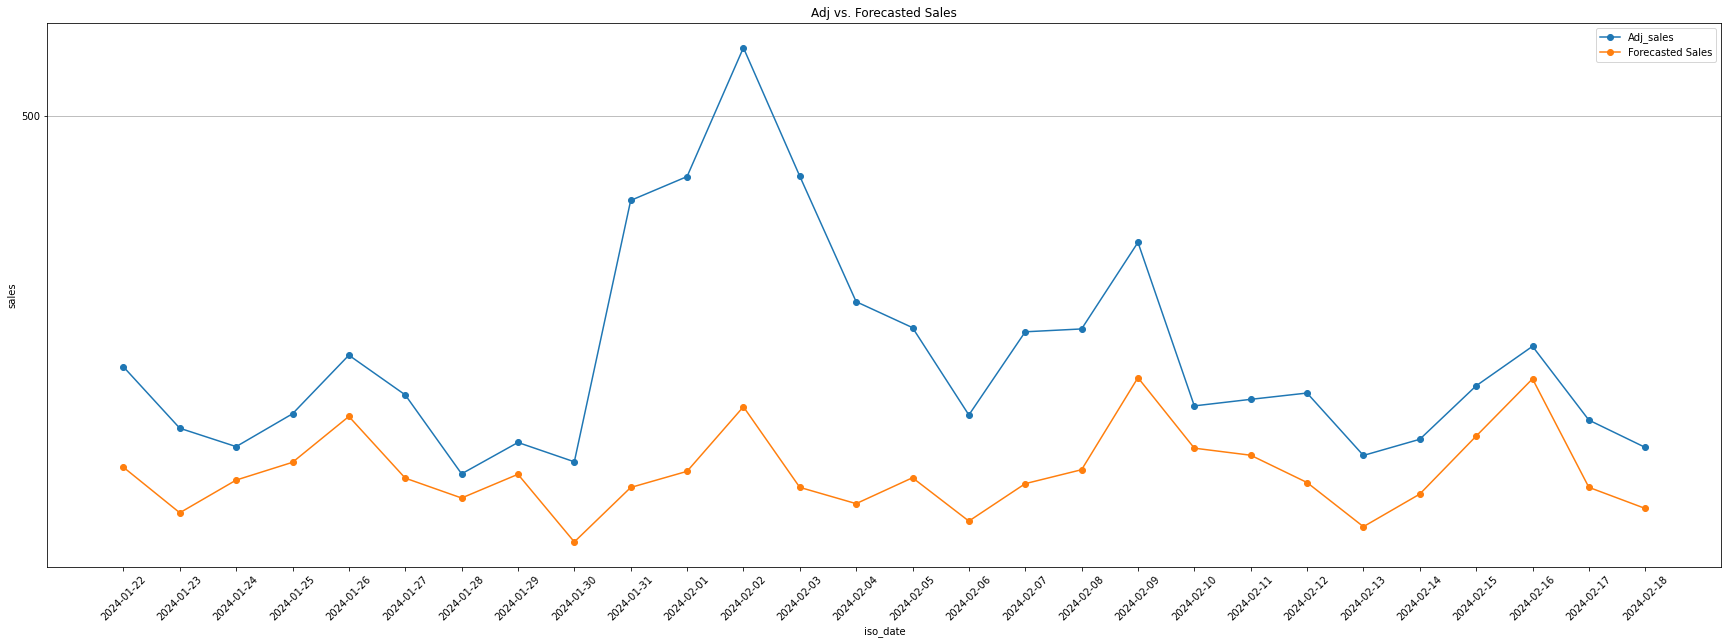

In [131]:
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator  # Import MultipleLocator

plt.figure(figsize=(30, 10))
plt.plot(df_analysis_fcst['iso_date'],df_analysis_fcst['adj_sales'],linestyle=None,marker='o',label='Adj_sales')
plt.plot(df_analysis_fcst['iso_date'], df_analysis_fcst['yhat'],marker='o', label='Forecasted Sales')

plt.xticks(df_analysis_fcst['iso_date'],rotation=45)
plt.xlabel('iso_date')

# Set y-axis ticks at intervals of 500
plt.gca().yaxis.set_major_locator(MultipleLocator(500))
# Add horizontal gridlines only
plt.gca().grid(axis='y')

plt.ylabel('sales')
plt.title('Adj vs. Forecasted Sales')
plt.legend()
plt.show()

# Best params

In [ ]:
        #PARAMETERS
        m = Prophet(growth='logistic',holidays=df_bh_pay,daily_seasonality=False,weekly_seasonality=False,yearly_seasonality=False,changepoint_prior_scale=0.1,seasonality_prior_scale=0.015)
        m.add_country_holidays(country_name=country)
        m.add_seasonality(name='monthly',period=30.25,fourier_order=5,prior_scale=0.001)
        if week_std < 0.015:
            m.add_seasonality(name='weekly', period=7, fourier_order=5,prior_scale=0.001)    
        else:
            m.add_seasonality(name='weekly', period=7, fourier_order=10)
        if str(rms)[:3] == '112':
            if  seasonality_ratio > 7:
                m.add_seasonality(name='yearly', period=365.25,fourier_order=20)
                m.add_regressor('scaled_tpnb_count', prior_scale=0.015)
                m.add_regressor('scaled_total_price',prior_scale=0.015)
                m.add_regressor('PC1',prior_scale=0.005)
                m.add_regressor('PC2',prior_scale=0.005)
            elif seasonality_ratio > 3:
                m.add_seasonality(name='yearly', period=365.25, fourier_order=6)
                m.add_regressor('scaled_tpnb_count', prior_scale=0.0015)
                m.add_regressor('scaled_total_price',prior_scale=0.015)
                m.add_regressor('PC1',prior_scale=0.01)
                m.add_regressor('PC2',prior_scale=0.01)
            else:
                m.add_seasonality(name='yearly', period=365.25, fourier_order=3)
                m.add_regressor('scaled_tpnb_count', prior_scale=0.0015)
                m.add_regressor('scaled_total_price',prior_scale=0.015)
                m.add_regressor('PC1',prior_scale=0.01)
                m.add_regressor('PC2',prior_scale=0.01)
        elif str(rms)[:3] == '114':
            m.add_regressor('scaled_tpnb_count', prior_scale=0.015)
            m.add_regressor('scaled_total_price',prior_scale=0.015)
            m.add_regressor('PC1',prior_scale=0.01)
            m.add_regressor('PC2',prior_scale=0.01)
            if  seasonality_ratio > 7:
                m.add_seasonality(name='yearly', period=365.25,fourier_order=10)
            elif seasonality_ratio > 3:
                m.add_seasonality(name='yearly', period=365.25, fourier_order=3)
            else:
                m.add_seasonality(name='yearly', period=365.25, fourier_order=1)
        elif str(rms)[:3] == '113':
            m.add_regressor('scaled_tpnb_count', prior_scale=0.001)
            m.add_regressor('scaled_total_price',prior_scale=0.001) # 0.015
            m.add_regressor('PC1',prior_scale=0.01)
            #m.add_regressor('PC2',prior_scale=0.01)
            if seasonality_ratio > 3: 
                m.add_seasonality(name='yearly', period=365.25,fourier_order=3) 
            else:
                m.add_seasonality(name='yearly', period=365.25, fourier_order=1) 
#        m.add_regressor('BH_regressor',prior_scale=0.5,mode='multiplicative')
        data.drop(columns='seasonality_ratio',inplace=True)

# Test params

In [ ]:
        #PARAMETERS
        m = Prophet(growth='logistic',holidays=df_bh_pay,daily_seasonality=False,weekly_seasonality=False,yearly_seasonality=False,changepoint_prior_scale=0.1,seasonality_prior_scale=0.006)
        m.add_country_holidays(country_name=country)
        m.add_seasonality(name='monthly',period=30.25,fourier_order=5,prior_scale=0.001)
        if week_std < 0.015:
            m.add_seasonality(name='weekly', period=7, fourier_order=5,prior_scale=0.001)    
        else:
            m.add_seasonality(name='weekly', period=7, fourier_order=10)
        if str(rms)[:3] == '112':
            if  seasonality_ratio > 8:
                m.add_seasonality(name='yearly', period=365.25,fourier_order=20)
                m.add_regressor('scaled_tpnb_count', prior_scale=0.015)
                m.add_regressor('scaled_total_price',prior_scale=0.015)
                m.add_regressor('PC1',prior_scale=0.15)
                m.add_regressor('PC2',prior_scale=0.05)
            elif seasonality_ratio > 3:
                m.add_seasonality(name='yearly', period=365.25, fourier_order=15)
                m.add_regressor('scaled_tpnb_count', prior_scale=0.0015)
                m.add_regressor('scaled_total_price',prior_scale=15)
                m.add_regressor('PC1',prior_scale=0.01)
                m.add_regressor('PC2',prior_scale=0.01)
            else:
                m.add_seasonality(name='yearly', period=365.25, fourier_order=9)
                m.add_regressor('scaled_tpnb_count', prior_scale=0.0015)
                m.add_regressor('scaled_total_price',prior_scale=0.015)
                m.add_regressor('PC1',prior_scale=0.01)
                m.add_regressor('PC2',prior_scale=0.01)
        elif str(rms)[:3] == '114':
            m.add_regressor('scaled_tpnb_count', prior_scale=0.015)
            m.add_regressor('scaled_total_price',prior_scale=0.015)
            m.add_regressor('PC1',prior_scale=0.01)
            m.add_regressor('PC2',prior_scale=0.01)
            if  seasonality_ratio > 7:
                m.add_seasonality(name='yearly', period=365.25,fourier_order=10)
            elif seasonality_ratio > 3:
                m.add_seasonality(name='yearly', period=365.25, fourier_order=3)
            else:
                m.add_seasonality(name='yearly', period=365.25, fourier_order=1)
        elif str(rms)[:3] == '113':
            m.add_regressor('scaled_tpnb_count', prior_scale=0.001)
            m.add_regressor('scaled_total_price',prior_scale=0.001) # 0.015
            m.add_regressor('PC1',prior_scale=0.01)
            #m.add_regressor('PC2',prior_scale=0.01)
            if seasonality_ratio > 3: 
                m.add_seasonality(name='yearly', period=365.25,fourier_order=3) 
            else:
                m.add_seasonality(name='yearly', period=365.25, fourier_order=1) 
#        m.add_regressor('BH_regressor',prior_scale=0.5,mode='multiplicative')
        data.drop(columns='seasonality_ratio',inplace=True)

In [ ]:
        #PARAMETERS
        if str(rms)[:3] == '112':
            m = Prophet(growth='logistic',holidays=df_bh_pay,daily_seasonality=False,weekly_seasonality=False,yearly_seasonality=False,changepoint_prior_scale=0.5,seasonality_prior_scale=0.5)
        else:
            m = Prophet(growth='logistic',holidays=df_bh_pay,daily_seasonality=False,weekly_seasonality=False,yearly_seasonality=False,changepoint_prior_scale=0.5,seasonality_prior_scale=0.015)     
        m.add_country_holidays(country_name=country)
        m.add_seasonality(name='monthly',period=30.25,fourier_order=5,prior_scale=0.001)
        if week_std < 0.015 or seasonality_ratio > 7:
            m.add_seasonality(name='weekly', period=7, fourier_order=5,prior_scale=0.001)    
        else:
            m.add_seasonality(name='weekly', period=7, fourier_order=10)
        if str(rms)[:3] == '112':
            if  seasonality_ratio > 7:
                m.add_seasonality(name='yearly', period=365.25,fourier_order=20)
                m.add_regressor('scaled_tpnb_count', prior_scale=0.015,mode='multiplicative')
                m.add_regressor('scaled_total_price',prior_scale=0.015,mode='multiplicative')
                m.add_regressor('PC1',prior_scale=0.15,mode='multiplicative')
                m.add_regressor('PC2',prior_scale=0.005,mode='multiplicative')
            elif seasonality_ratio > 3:
                m.add_seasonality(name='yearly', period=365.25, fourier_order=15)
                m.add_regressor('scaled_tpnb_count', prior_scale=0.0015,mode='multiplicative')
                m.add_regressor('scaled_total_price',prior_scale=0.015,mode='multiplicative')
                m.add_regressor('PC1',prior_scale=0.01,mode='multiplicative')
                m.add_regressor('PC2',prior_scale=0.01,mode='multiplicative')
            else:
                m.add_seasonality(name='yearly', period=365.25, fourier_order=9)
                m.add_regressor('scaled_tpnb_count', prior_scale=0.0015,mode='multiplicative')
                m.add_regressor('scaled_total_price',prior_scale=0.015,mode='multiplicative')
                m.add_regressor('PC1',prior_scale=0.01,mode='multiplicative')
                m.add_regressor('PC2',prior_scale=0.01,mode='multiplicative')
        elif str(rms)[:3] == '114':
            m.add_regressor('scaled_tpnb_count', prior_scale=0.015,mode='multiplicative')
            m.add_regressor('scaled_total_price',prior_scale=0.015,mode='multiplicative')
            m.add_regressor('PC1',prior_scale=0.01,mode='multiplicative')
            m.add_regressor('PC2',prior_scale=0.01,mode='multiplicative')
            if  seasonality_ratio > 7:
                m.add_seasonality(name='yearly', period=365.25,fourier_order=15) #10
            elif seasonality_ratio > 3:
                m.add_seasonality(name='yearly', period=365.25, fourier_order=5) #3
            else:
                m.add_seasonality(name='yearly', period=365.25, fourier_order=1,prior_scale=0.001) #1
        elif str(rms)[:3] == '113':
            m.add_regressor('scaled_tpnb_count', prior_scale=0.001,mode='multiplicative')
            m.add_regressor('scaled_total_price',prior_scale=0.001,mode='multiplicative') # 0.015
            m.add_regressor('PC1',prior_scale=0.01,mode='multiplicative')
            #m.add_regressor('PC2',prior_scale=0.01,mode='multiplicative')
            if seasonality_ratio > 3: 
                m.add_seasonality(name='yearly', period=365.25,fourier_order=3) 
            else:
                m.add_seasonality(name='yearly', period=365.25, fourier_order=1) 
        m.add_regressor('small_payweek',prior_scale=0.05,mode='additive')
        m.add_regressor('large_payweek',prior_scale=0.05,mode='additive')
        data.drop(columns='seasonality_ratio',inplace=True)